# Description

This notebooks performs QA checks for CryptoChassis Futures OHLCV data:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.crypto_chassis.data.client as iccdc
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-19e544d3-7752-4d81-b64a-18342f8ea1f9.json'
INFO  # Git
    branch_name='master'
    hash='3e23344c9'
    # Last commits:
      * 3e23344c9 DanilYachmenev Cm task2176 add futures to im client (#2193)                      (  26 hours ago) Wed Jun 22 14:24:55 2022  (HEAD -> master, origin/master, origin/HEAD)
      * cbce699c2 Daniil Tikhomirov CMTask2168: Update docstrings (#2196)                             (  27 hours ago) Wed Jun 22 13:07:10 2022           
      * 5b307e0cd Nina Lee Cm task2090 create a resampling script for bid/ask data (#2112)   (    2 days ago) Tue Jun 21 16:45:34 2022           
# Machine info
    system=Linux
    node name=db11d3f47115
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu count=8
    cpu freq=scpufreq(current=2499.998, min=0.0, max=0.0)
    memory=sv

# Configs

In [3]:
def get_cmtask2187_config() -> cconconf.Config:
    """
    Get task2187-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v2",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "dataset": "ohlcv",
                "contract_type": "futures",
                "data_snapshot": "20220620",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [5]:
config = get_cmtask2187_config()
print(config)

data:
  im_client:
    universe_version: v2
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 20220620
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [6]:
client = iccdc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["im_client"]
)

In [7]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::SOL_USDT',
 'coinbase::BTC_USDT',
 'coinbase::DOGE_USDT',
 'coinbase::ETH_USDT',
 'coinbase::SOL_USDT',
 'ftx::BNB_USDT',
 'ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::ETH_USDT',
 'ftx::SOL_USDT',
 'ftx::XRP_USDT',
 'gateio::ADA_USDT',
 'gateio::BNB_USDT',
 'gateio::BTC_USDT',
 'gateio::DOGE_USDT',
 'gateio::EOS_USDT',
 'gateio::ETH_USDT',
 'gateio::SOL_USDT',
 'gateio::XRP_USDT',
 'kucoin::ADA_USDT',
 'kucoin::BNB_USDT',
 'kucoin::BTC_USDT',
 'kucoin::DOGE_USDT',
 'kucoin::EOS_USDT',
 'kucoin::ETH_USDT',
 'kucoin::SOL_USDT',
 'kucoin::XRP_USDT']

## Binance

In [8]:
binance_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("binance")
]
binance_universe

['binance::ADA_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::SOL_USDT']

In [9]:
binance_data = client.read_data(binance_universe, **config["data"]["read_data"])
binance_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-08-07 00:00:00+00:00,binance::ADA_USDT,1.4018,236179.000
2021-08-07 00:00:00+00:00,binance::BNB_USDT,341.9400,1240.180
2021-08-07 00:00:00+00:00,binance::BTC_USDT,42790.2900,599.745


In [10]:
vendor_name = "CryptoChassis"
binance_timestamp_stats = ramccqa.get_timestamp_stats(binance_data, vendor_name)
binance_timestamp_stats

,min_timestamp,max_timestamp,days_available
binance::ADA_USDT,2021-08-07 00:00:00+00:00,2022-06-19 23:59:00+00:00,316
binance::BNB_USDT,2021-08-07 00:00:00+00:00,2022-06-19 23:59:00+00:00,316
binance::BTC_USDT,2021-08-07 00:00:00+00:00,2022-06-19 23:59:00+00:00,316
binance::DOGE_USDT,2021-08-07 00:00:00+00:00,2022-06-19 23:59:00+00:00,316
binance::EOS_USDT,2021-08-07 00:00:00+00:00,2022-06-19 23:59:00+00:00,316
binance::ETH_USDT,2021-08-07 00:00:00+00:00,2022-06-19 23:59:00+00:00,316
binance::SOL_USDT,2021-10-13 17:49:00+00:00,2022-06-19 23:59:00+00:00,249


In [11]:
agg_level_full_symbol = ["full_symbol"]
binance_bad_data_stats = ramccqa.get_bad_data_stats(
    binance_data, agg_level_full_symbol, vendor_name
)
binance_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
binance::ADA_USDT,0.242508,0.242508,0.0,0.0
binance::BNB_USDT,0.058053,0.058053,0.0,0.0
binance::BTC_USDT,0.047976,0.047976,0.0,0.0
binance::DOGE_USDT,0.055862,0.055862,0.0,0.0
binance::EOS_USDT,0.050166,0.050166,0.0,0.0
binance::ETH_USDT,0.053233,0.053233,0.0,0.0
binance::SOL_USDT,0.258267,0.258267,0.0,0.0


In [12]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
binance_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    binance_data, agg_level_full_symbol_year_month, vendor_name
)
binance_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
binance::ADA_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.118056          0.118056           0.0       0.0
                        10      0.483871          0.483871           0.0       0.0
                        11      0.025463          0.025463           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.000000          0.000000           0.0       0.0
                        4       1.703704          1.703704           0.0       0.0
                        5       0.201613          0.201613           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
binance::BNB_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.120370          0.120370           0.0       0.0
                        10      0.259857          0.259857           0.0       0.0
                        11      0.002315          0.002315           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.064964          0.064964           0.0       0.0
                        4       0.000000          0.000000           0.0       0.0
                        5       0.143369          0.143369           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
binance::BTC_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.148148          0.148148           0.0       0.0
                        10      0.194892          0.194892           0.0       0.0
                        11      0.002315          0.002315           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.000000          0.000000           0.0       0.0
                        4       0.000000          0.000000           0.0       0.0
                        5       0.143369          0.143369           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
binance::DOGE_USDT 2021 8       0.008333          0.008333           0.0       0.0
                        9       0.148148          0.148148           0.0       0.0
                        10      0.275538          0.275538           0.0       0.0
                        11      0.002315          0.002315           0.0       0.0
                        12      0.000000          0.000000           0.0       0.0
                   2022 1       0.000000          0.000000           0.0       0.0
                        2       0.000000          0.000000           0.0       0.0
                        3       0.000000          0.000000           0.0       0.0
                        4       0.000000          0.000000           0.0       0.0
                        5       0.143369          0.143369           0.0       0.0
                        6       0.000000          0.000000           0.0       0.0
binance::EOS_USDT  2021 8       0.008333          0.008333           0.0       0.0
                        9       0.148148          0.148148           0.0       0.0
                        10      0.210573          0.210573           0.0       0.0
                        11      0.002315    

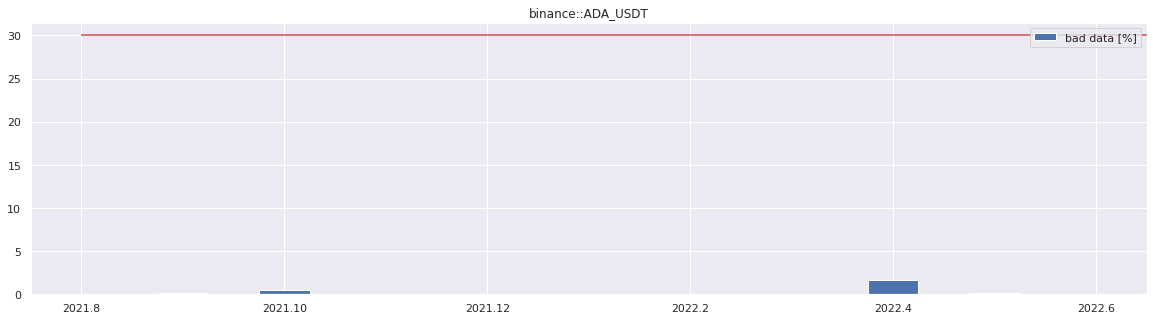

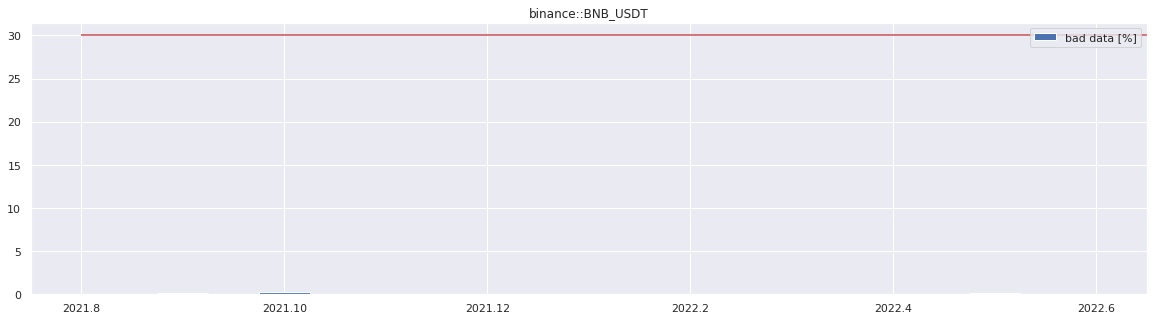

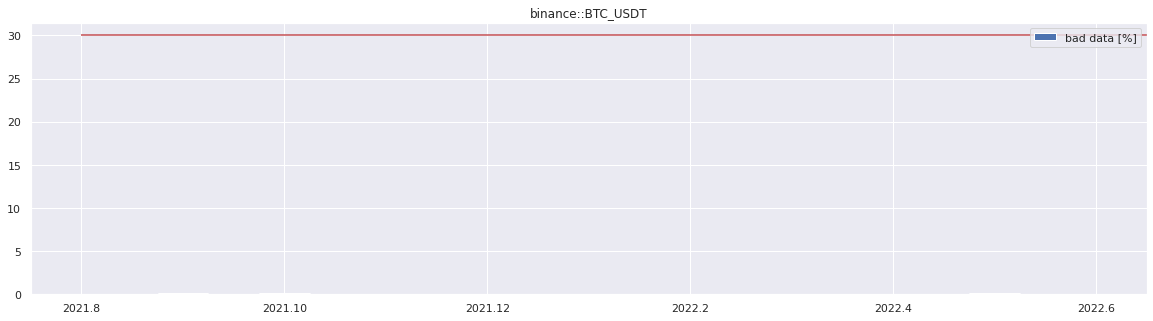

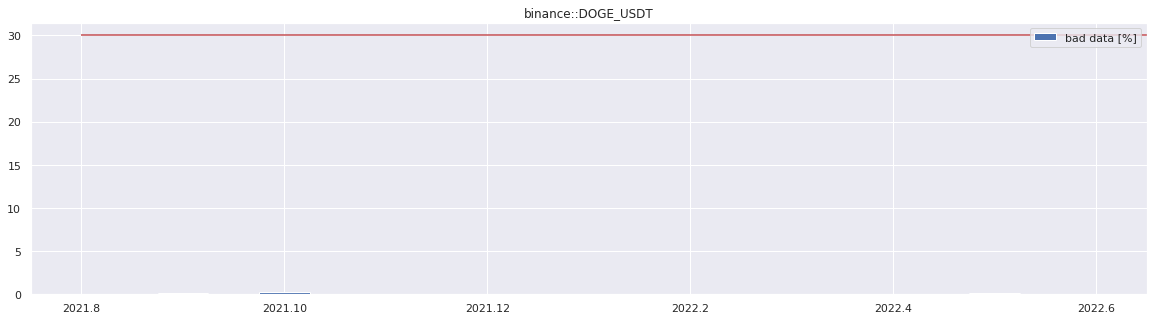

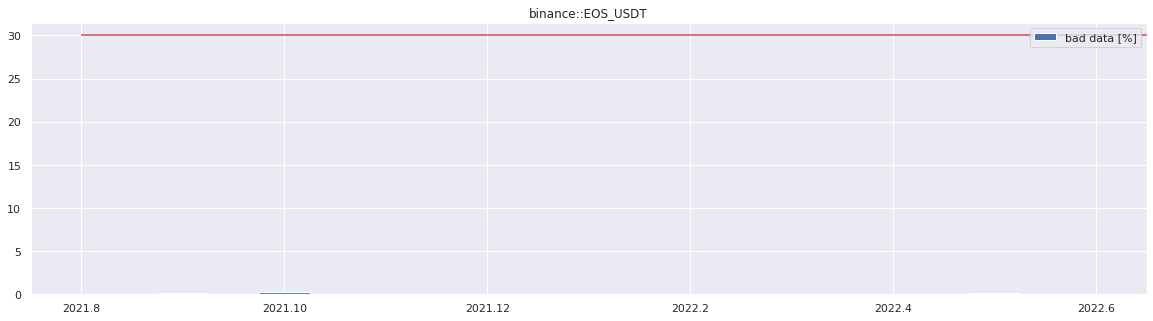

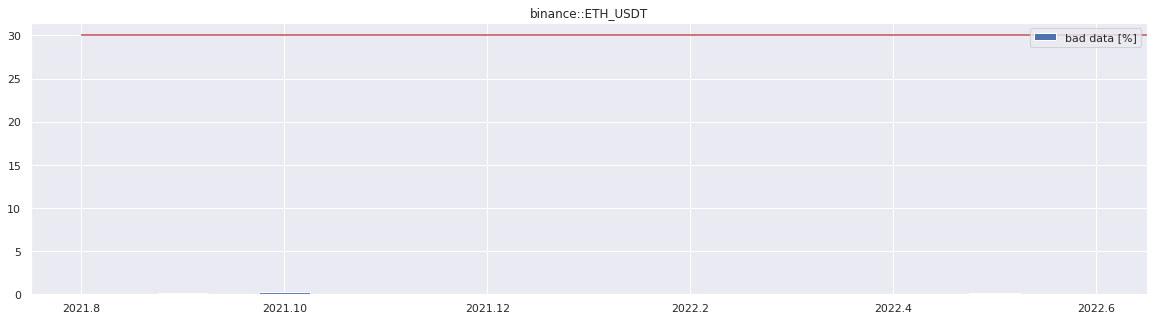

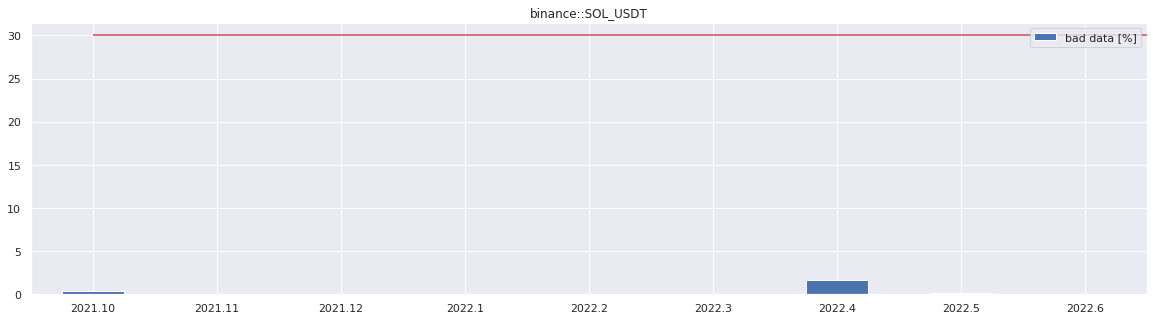

In [13]:
_ = ramccqa.plot_bad_data_by_year_month_stats(
    binance_bad_data_stats_by_year_month, config["stats"]["threshold"]
)